# 예측모델 만들기

## Preprocessing

### improt library

In [111]:
!pip install plotly --upgrade

    100% |████████████████████████████████| 38.4MB 1.1MB/s 
  Running setup.py bdist_wheel for retrying ... - done
  Stored in directory: /root/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
  Found existing installation: plotly 1.12.12
    Uninstalling plotly-1.12.12:
      Successfully uninstalled plotly-1.12.12


In [116]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 데이터 가져오기

In [0]:
data = pd.read_csv('gdrive/My Drive/공모전/Lpoint/데이터셋 만들기/lotte_drama.csv')
data.rename(columns = {'CLAC1_NM':'분류','CLAC2_NM':'중분류'},inplace = True)
data = pd.get_dummies(data,columns = ['분류','중분류'])
target = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score1.csv')
target2 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score2.csv')
dataset = pd.merge(data,target, how = 'inner', on=['LABEL']).set_index('LABEL')
dataset2 = pd.merge(data,target2, how = 'inner', on=['LABEL']).set_index('LABEL')

In [0]:
data2 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/데이터셋 만들기/mlotte_drama.csv')
data2.rename(columns = {'CLAC1_NM':'분류','CLAC2_NM':'중분류'},inplace = True)
data2 = pd.get_dummies(data2,columns = ['분류','중분류'])
target21 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score12.csv')
target22 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score22.csv')
testset = pd.merge(data2,target21, how = 'inner', on=['LABEL']).set_index('LABEL')
testset2 = pd.merge(data2,target22, how = 'inner', on=['LABEL']).set_index('LABEL')

In [38]:
dataset[['PD_BUY_AM','PD_BUY_CT','PD_SALES','BRA_SC','CLAC3_SC','SCORE']].corr('pearson')

,PD_BUY_AM,PD_BUY_CT,PD_SALES,BRA_SC,CLAC3_SC,SCORE
PD_BUY_AM,1.000000,-0.064173,0.061755,-0.054930,0.015493,0.038257
PD_BUY_CT,-0.064173,1.000000,0.807087,0.003129,0.077067,0.016302
PD_SALES,0.061755,0.807087,1.000000,0.012561,0.050767,0.014349
BRA_SC,-0.054930,0.003129,0.012561,1.000000,0.041518,0.032633
CLAC3_SC,0.015493,0.077067,0.050767,0.041518,1.000000,-0.064744
SCORE,0.038257,0.016302,0.014349,0.032633,-0.064744,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5db93b3cf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5db93b3cf8>)

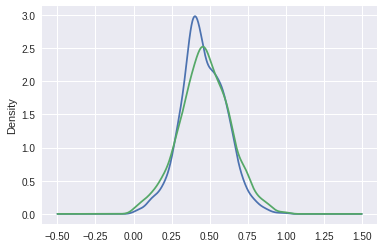

In [39]:
dataset['SCORE'].plot.density(), dataset2['SCORE2'].plot.density()

### 데이터 전처리

In [0]:
# bins = [dataset['SCORE'].quantile(i*0.25) for i in range(5)]
bins = [i*.25 for i in range(5)]
# labels = ['Fine','Good','Great','Perfect']
labels = range(4)
dataset['SCORE']=pd.cut(dataset['SCORE'], bins = bins, labels = labels)
dataset2['SCORE2']=pd.cut(dataset2['SCORE2'], bins = bins, labels = labels)
testset['SCORE']=pd.cut(testset['SCORE'], bins = bins, labels = labels)
testset2['SCORE2']=pd.cut(testset2['SCORE2'], bins = bins, labels = labels)

In [0]:
# dataset['SCORE'][dataset['SCORE'].isnull()] = 'Fine'
# dataset2['SCORE2'][dataset2['SCORE2'].isnull()] = 'Fine'
# testset['SCORE'][testset['SCORE'].isnull()] = 'Fine'
# testset2['SCORE2'][testset2['SCORE2'].isnull()] = 'Fine'
dataset['SCORE'][dataset['SCORE'].isnull()] = 0
dataset2['SCORE2'][dataset2['SCORE2'].isnull()] = 0
testset['SCORE'][testset['SCORE'].isnull()] = 0
testset2['SCORE2'][testset2['SCORE2'].isnull()] = 0

In [52]:
# trainset = dataset2[:-2735] 
# testset = testset[-2735:]
# # X_train, y_train = trainset.iloc[:,:-1], trainset['SCORE2']
# # X_test, y_test = testset.iloc[:,:-1], testset['SCORE2']
# trainset = dataset[:-2735] 
# testset = dataset[-2735:]
# X_train, y_train = trainset.iloc[:,:-1], trainset['SCORE']
# X_test, y_test = testset.iloc[:,:-1], testset['SCORE']
X_train, y_train = dataset.iloc[:,:-1], dataset['SCORE']
X_test, y_test = testset.iloc[:,:-1], testset['SCORE']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4157, 73), (4157,), (16571, 73), (16571,))

In [0]:
from sklearn.preprocessing import StandardScaler

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [54]:
X_train.shape[0]

4157

## Models

In [0]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
# Class to extend XGboost classifer

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [0]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'bootstrap': True,
    'n_jobs': -1,
    'n_estimators': 200,
     'warm_start': True, 
    'max_depth': 10,
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'max_features' : 'auto',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':1600,
    'max_features': 'sqrt',
    'max_depth': 10,
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 20,
    'learning_rate' : 0.35
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_features': auto,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [0]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)

In [92]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_train, y_train, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost

print("Training is complete")

Training is complete


In [0]:
rf_feature = rf.feature_importances(X_train,y_train)
et_feature = et.feature_importances(X_train, y_train)
ada_feature = ada.feature_importances(X_train, y_train)
gb_feature = gb.feature_importances(X_train,y_train)

In [100]:
len(rf_feature),len(et_feature),len(ada_feature),len(gb_feature),len(dataset.columns.values)

(73, 73, 73, 73, 74)

In [0]:
cols = dataset.iloc[:,:-1].columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [102]:
feature_dataframe.head()

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.090,0.020180,0.123237,0.062792,PD_BUY_AM
1,0.024,0.010582,0.026460,0.038736,PD_BUY_CT
2,0.184,0.010878,0.131517,0.047811,PD_SALES
3,0.098,0.017351,0.085226,0.030102,BRA_SC
4,0.086,0.027519,0.047196,0.028227,CLAC3_SC


In [130]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.sort_values(by=['mean'],ascending=False).head(10)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
2,0.184,0.010878,0.131517,0.047811,PD_SALES,0.093552
52,0.006,0.176162,0.041368,0.111724,중분류_메이크업,0.083813
0,0.090,0.020180,0.123237,0.062792,PD_BUY_AM,0.074052
55,0.012,0.124280,0.030294,0.079106,중분류_보석,0.061420
3,0.098,0.017351,0.085226,0.030102,BRA_SC,0.057670
4,0.086,0.027519,0.047196,0.028227,CLAC3_SC,0.047236
22,0.062,0.012209,0.044456,0.053856,Desktop,0.043130
66,0.010,0.061950,0.011621,0.038689,중분류_여성화,0.030565
23,0.024,0.013351,0.034158,0.034977,Mobile,0.026621
41,0.002,0.069339,0.009725,0.023931,분류_여성의류,0.026249


In [72]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,1.0,1.0,2.0,1.0
1,1.0,1.0,1.0,1.0
2,2.0,1.0,2.0,2.0
3,2.0,1.0,2.0,1.0
4,2.0,1.0,2.0,1.0


In [0]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

In [0]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [124]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)

# print(f'Out-of-bag score estimate: {best_grid.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.564


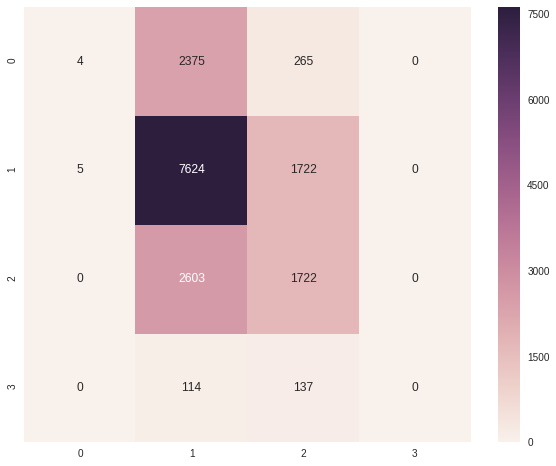

In [125]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,8))
cm = pd.DataFrame(confusion_matrix(y_test, predictions ))

sns.heatmap(cm, annot=True, fmt="d", xticklabels = labels, yticklabels = labels, annot_kws={"size": 12})